# Exploratory data analysis

In [1]:
import calendar

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns

import preprocessing

sns.set_theme(style="whitegrid")

In [2]:
df = pd.read_csv("../data/tournament_dataset/train.tsv", sep="\t")
df = preprocessing.add_derived_features(df)

## Target variable distribution

Histograms showing the overall distribution of the target variable and its natural logarithm in the training set:

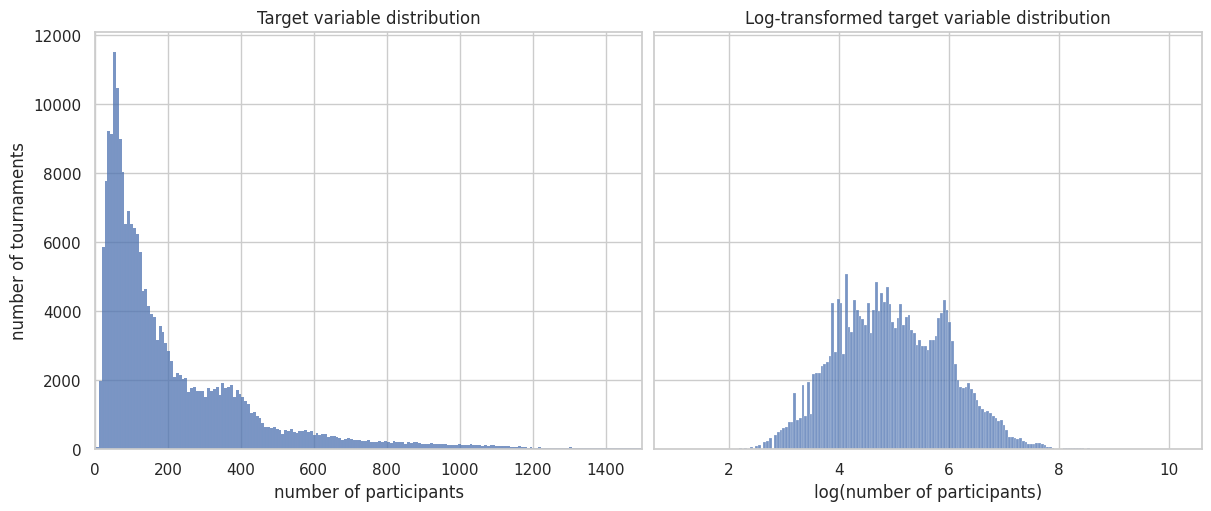

In [3]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 5), layout="compressed", sharey=True)

sns.histplot(df.n_players, ax=axs[0])
axs[0].set_title("Target variable distribution")
axs[0].set_xlabel("number of participants")
axs[0].set_ylabel("number of tournaments")
axs[0].set_xlim(0, 1500)

sns.histplot(np.log(df.n_players), ax=axs[1])
axs[1].set_title("Log-transformed target variable distribution")
axs[1].set_xlabel("log(number of participants)");

Although definitely not perfect, the distribution of the logarithm is much closer to a normal distribution. For this reason, for the training of all models in this project, I decided to apply a log transformation to the target variable (i. e. predict the natural logarithm of the number of players participating in a tournament). The rest of the plots in this EDA use a log scale for the target.

## Feature analysis

Almost every feature in the dataset for this problem is either categorical or binary. Even the ones that can be considered numeric have a relatively small number of unique values and lack a continuous distribution to analyze. However, the target variable *is* continuous. Therefore, in order to test the significance of each feature, I used statistical tests to compare the empirical distributions of the target variable for different values of the feature.

From the plots below it will become clear that the distributions in question can't be assumed to be normal, so I picked tests that don't rely on this.

I used the following tests:
- for binary features:
  - the [Mann-Whitney U test](https://en.wikipedia.org/wiki/Mann%E2%80%93Whitney_U_test) to check whether the two samples of the target value came from the same distribution
  - [Mood's median test](https://en.wikipedia.org/wiki/Median_test) to check if the medians of these distributions are the same
- for non-binary categorical features:
  - the [Kruskal-Wallis test](https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_test), an extension of Mann-Whitney for multiple samples
  - [Mood's median test](https://en.wikipedia.org/wiki/Median_test), which already works fine for multiple samples

In [4]:
def test_feature(col, desc, formatter=None, **kwargs):
    counts = df.groupby(col).n_players.count()

    displot_kwargs=dict(
        x="n_players", col=col, stat="proportion", common_norm=False, log_scale=True, bins=np.linspace(1, 3.5, 75),
        col_order=counts.sort_values(ascending=False).index, col_wrap=min(3, len(counts)), height=2, aspect=2,
        facet_kws={"despine": False},
    ) | kwargs
    grid = sns.displot(df,  **displot_kwargs)

    grid.figure.suptitle(f"Target value distributions by {desc}", y=1.03 if len(counts) >= 3 else 1.07)
    for val, ax in grid.axes_dict.items():
        ax.set_xlabel("number of participants")
        ax.set_ylabel("proportion")
        val_fmt = formatter(val) if formatter is not None else val
        ax.set_title(f"{val_fmt} ({counts[val]} samples)")

    samples = df.groupby(col).n_players.agg(list)
    if len(samples) == 2:
        print(f"Mann-Whitney U test: pvalue = {scipy.stats.mannwhitneyu(*samples).pvalue}")
    else:
        print(f"Kruskal-Wallis test: pvalue = {scipy.stats.kruskal(*samples).pvalue}")
    print(f"Median test: pvalue = {scipy.stats.median_test(*samples).pvalue}")


def just_stat_test_features(cols):
    rows = []
    for col in cols:
        row = {"feature": col}
        samples = df.groupby(col).n_players.agg(list)
        if len(samples) == 2:
            for key in samples.index:
                row[f"count_{key}"] = len(samples[key])
            row["mann_whitney"] = scipy.stats.mannwhitneyu(*samples).pvalue
        else:
            row["kruskal_wallis"] = scipy.stats.kruskal(*samples).pvalue
        row["moon_median"] = scipy.stats.median_test(*samples).pvalue
        rows.append(row)
    return pd.DataFrame(rows)

### Categorical features

Kruskal-Wallis test: pvalue = 0.0
Median test: pvalue = 0.0


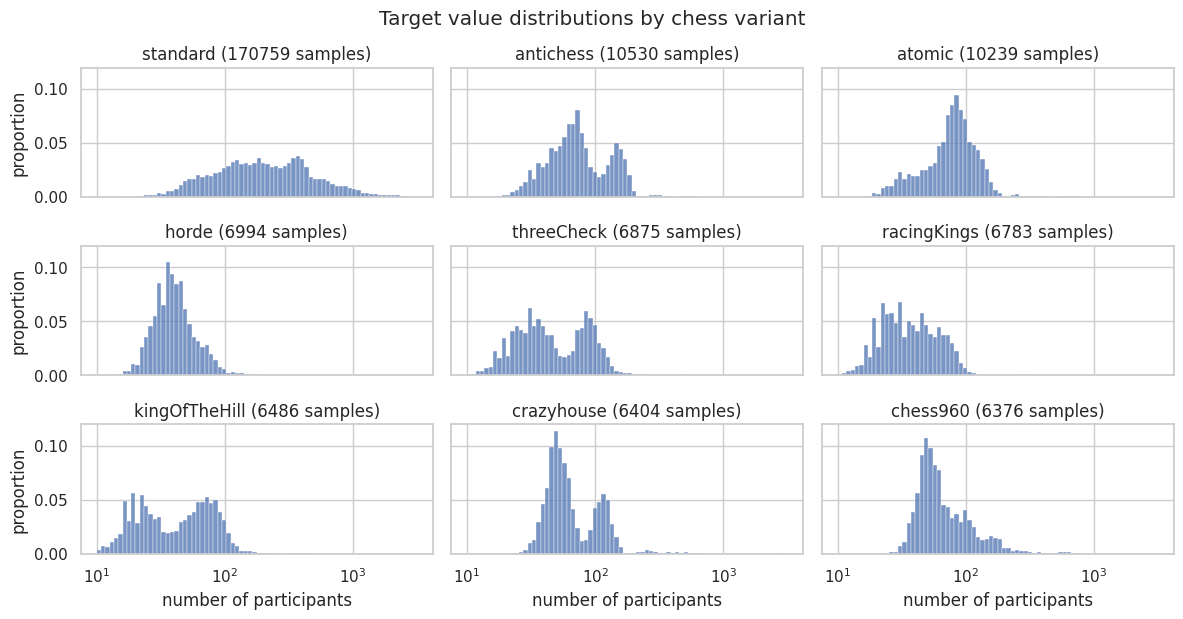

In [5]:
test_feature("variant", "chess variant")

Kruskal-Wallis test: pvalue = 0.0
Median test: pvalue = 0.0


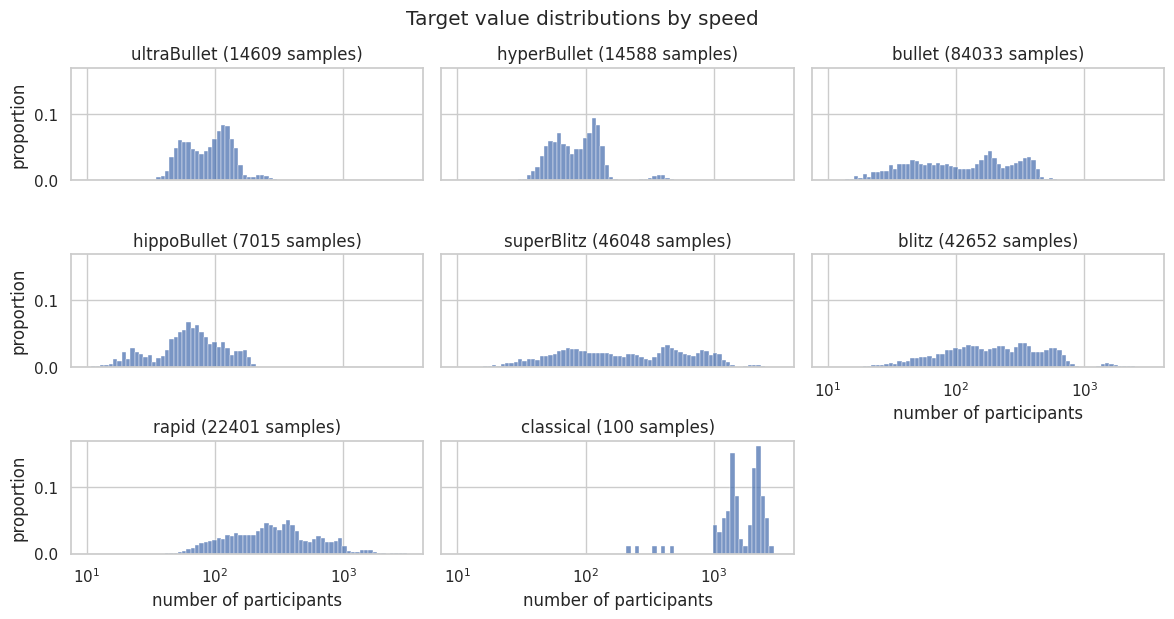

In [6]:
test_feature(
    "speed", "speed",
    col_order=["ultraBullet", "hyperBullet", "bullet", "hippoBullet", "superBlitz", "blitz", "rapid", "classical"]
)

Kruskal-Wallis test: pvalue = 0.0
Median test: pvalue = 0.0


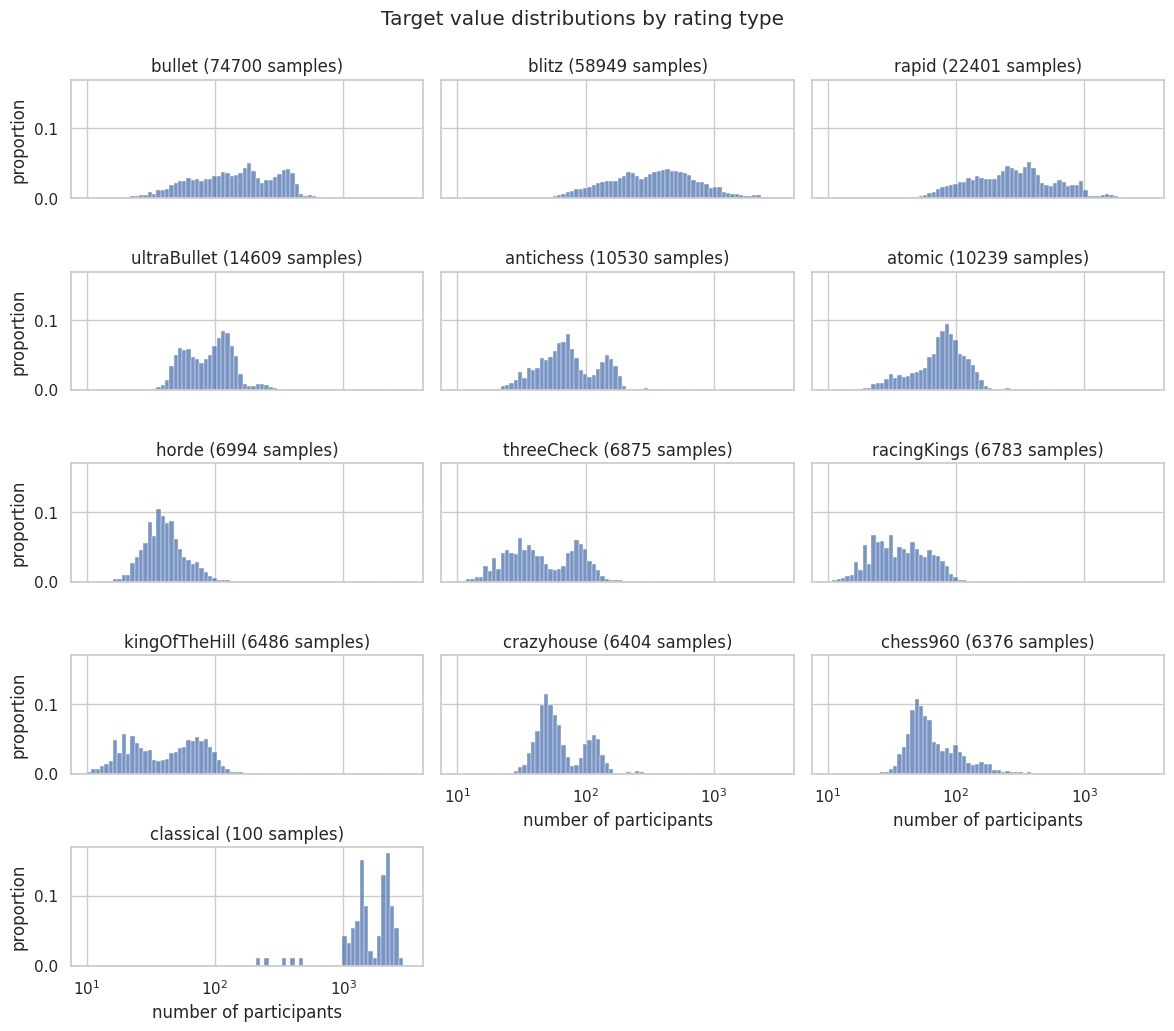

In [7]:
test_feature("perf", "rating type")

Kruskal-Wallis test: pvalue = 0.0
Median test: pvalue = 0.0


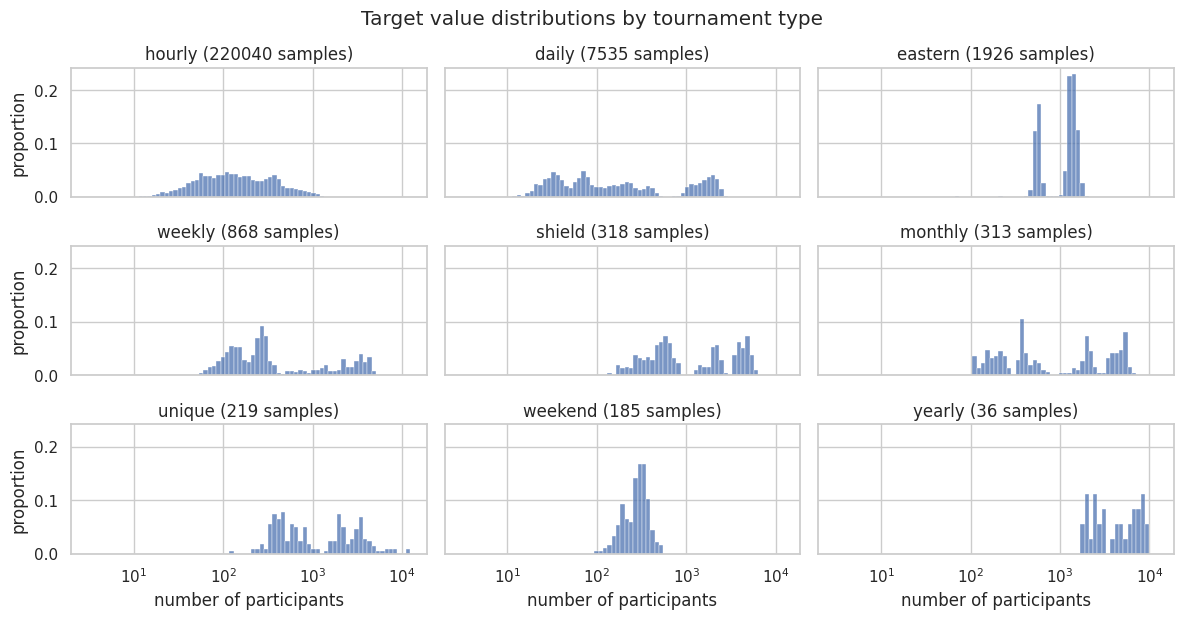

In [8]:
test_feature(df.freq[df.freq != "marathon"], "tournament type", bins=75)

The marathon histogram could not be plotted nicely with the rest of the data because the target values for it are very large. These are marathon tournaments -- massive 24-hour tournaments attended by lots of players. Each one in the training set has over 20,000 participants.

In [9]:
df[df.freq == "marathon"]

,id,n_players,name,starts_at,duration_mins,variant,perf,freq,speed,clock_limit_secs,...,starts_at_weekday,starts_at_hour,ends_at_hour,has_clock_increment,has_max_rating,has_min_rating,has_min_rated_games,has_custom_position,has_description,has_prizes
47370,summer24,20225,2024 Summer Marathon,2024-08-03T00:00:00Z,1440,standard,bullet,marathon,bullet,60,...,5,0,0,False,False,False,False,False,True,False
91826,summer23,21270,2023 Summer Marathon,2023-08-05T00:00:00Z,1440,standard,bullet,marathon,bullet,60,...,5,0,0,False,False,False,False,False,True,False
120732,autumn24,20555,2024 Autumn Marathon,2024-10-26T00:00:00Z,1440,standard,bullet,marathon,bullet,120,...,5,0,0,True,False,False,False,False,True,False
128359,winter23,25202,2023 Winter Marathon,2023-12-29T00:00:00Z,1440,standard,blitz,marathon,blitz,180,...,4,0,0,False,False,False,False,False,True,False
151273,spring23,24192,2023 Spring Marathon,2023-04-15T00:00:00Z,1440,standard,bullet,marathon,bullet,120,...,5,0,0,False,False,False,False,False,True,False
161410,autumn23,21615,2023 Autumn Marathon,2023-10-28T00:00:00Z,1440,standard,blitz,marathon,blitz,180,...,5,0,0,True,False,False,False,False,True,False


These categorical features are definitely very impactful on the prediction, which makes sense. A lot of these histograms look like they could be mixtures of several normal(-ish) distributions, with another factor affecting whether a sample gets "drawn" from one distribution or another (for example, three-check blitz vs. three-check bullet). These feature interactions are worth looking into in the future for feature engineering purposes. However, a good enough decision tree-based model could learn them on its own.

#### Starting date and time of the tournament

I also encoded the month, day of the week and hour of the starting time as categorical features.

Kruskal-Wallis test: pvalue = 1.090671370242191e-59
Median test: pvalue = 3.377764998736689e-46


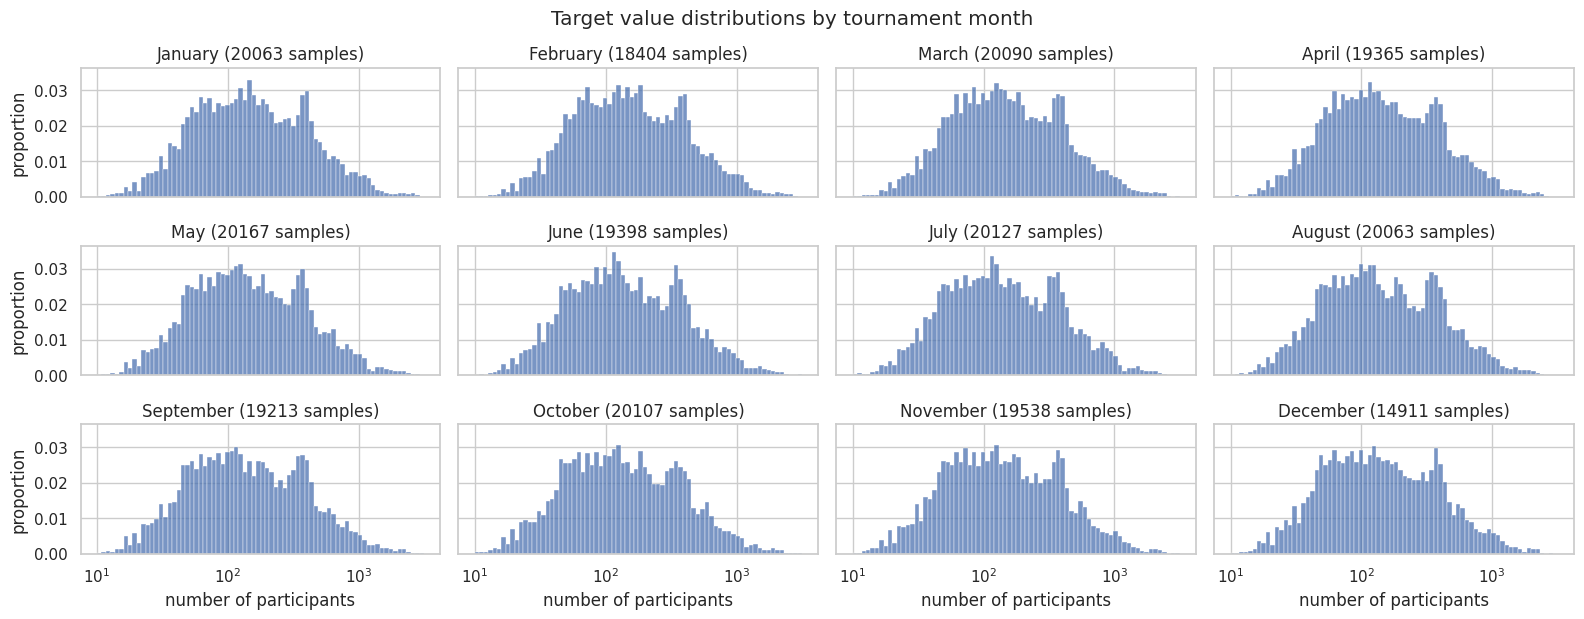

In [10]:
test_feature("starts_at_month", "tournament month", col_wrap=4, col_order=range(1, 13), formatter=lambda x: calendar.month_name[x])

Kruskal-Wallis test: pvalue = 4.0699302501736256e-20
Median test: pvalue = 1.514848476636006e-10


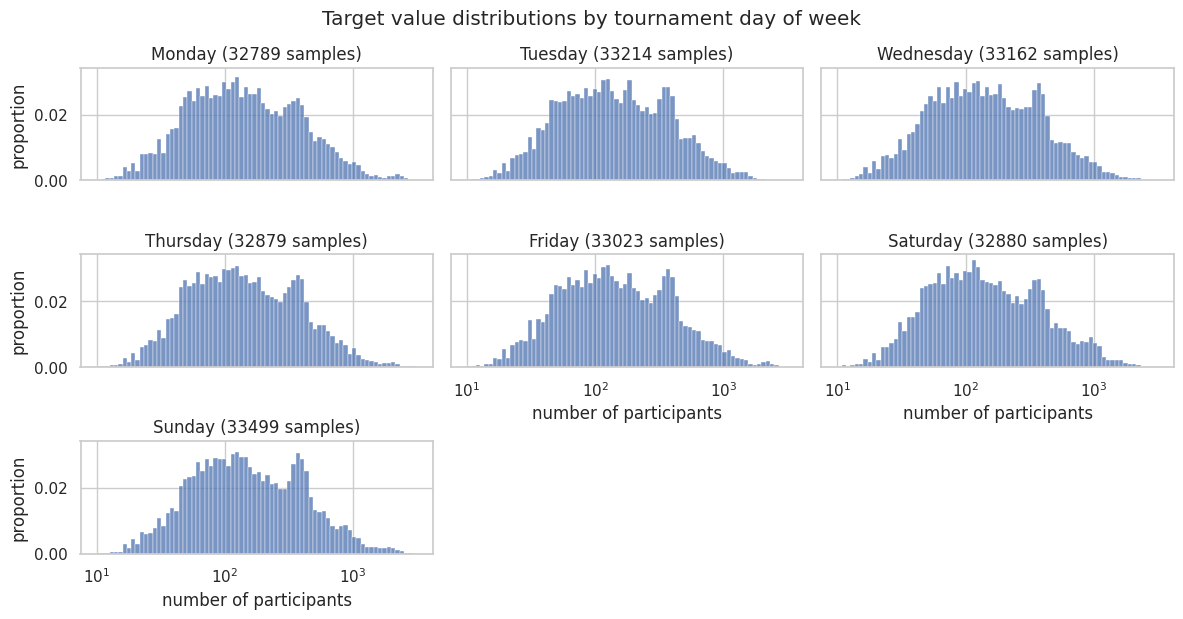

In [11]:
test_feature("starts_at_weekday", "tournament day of week", col_order=range(7), formatter=lambda x: calendar.day_name[x])

Kruskal-Wallis test: pvalue = 0.0
Median test: pvalue = 0.0


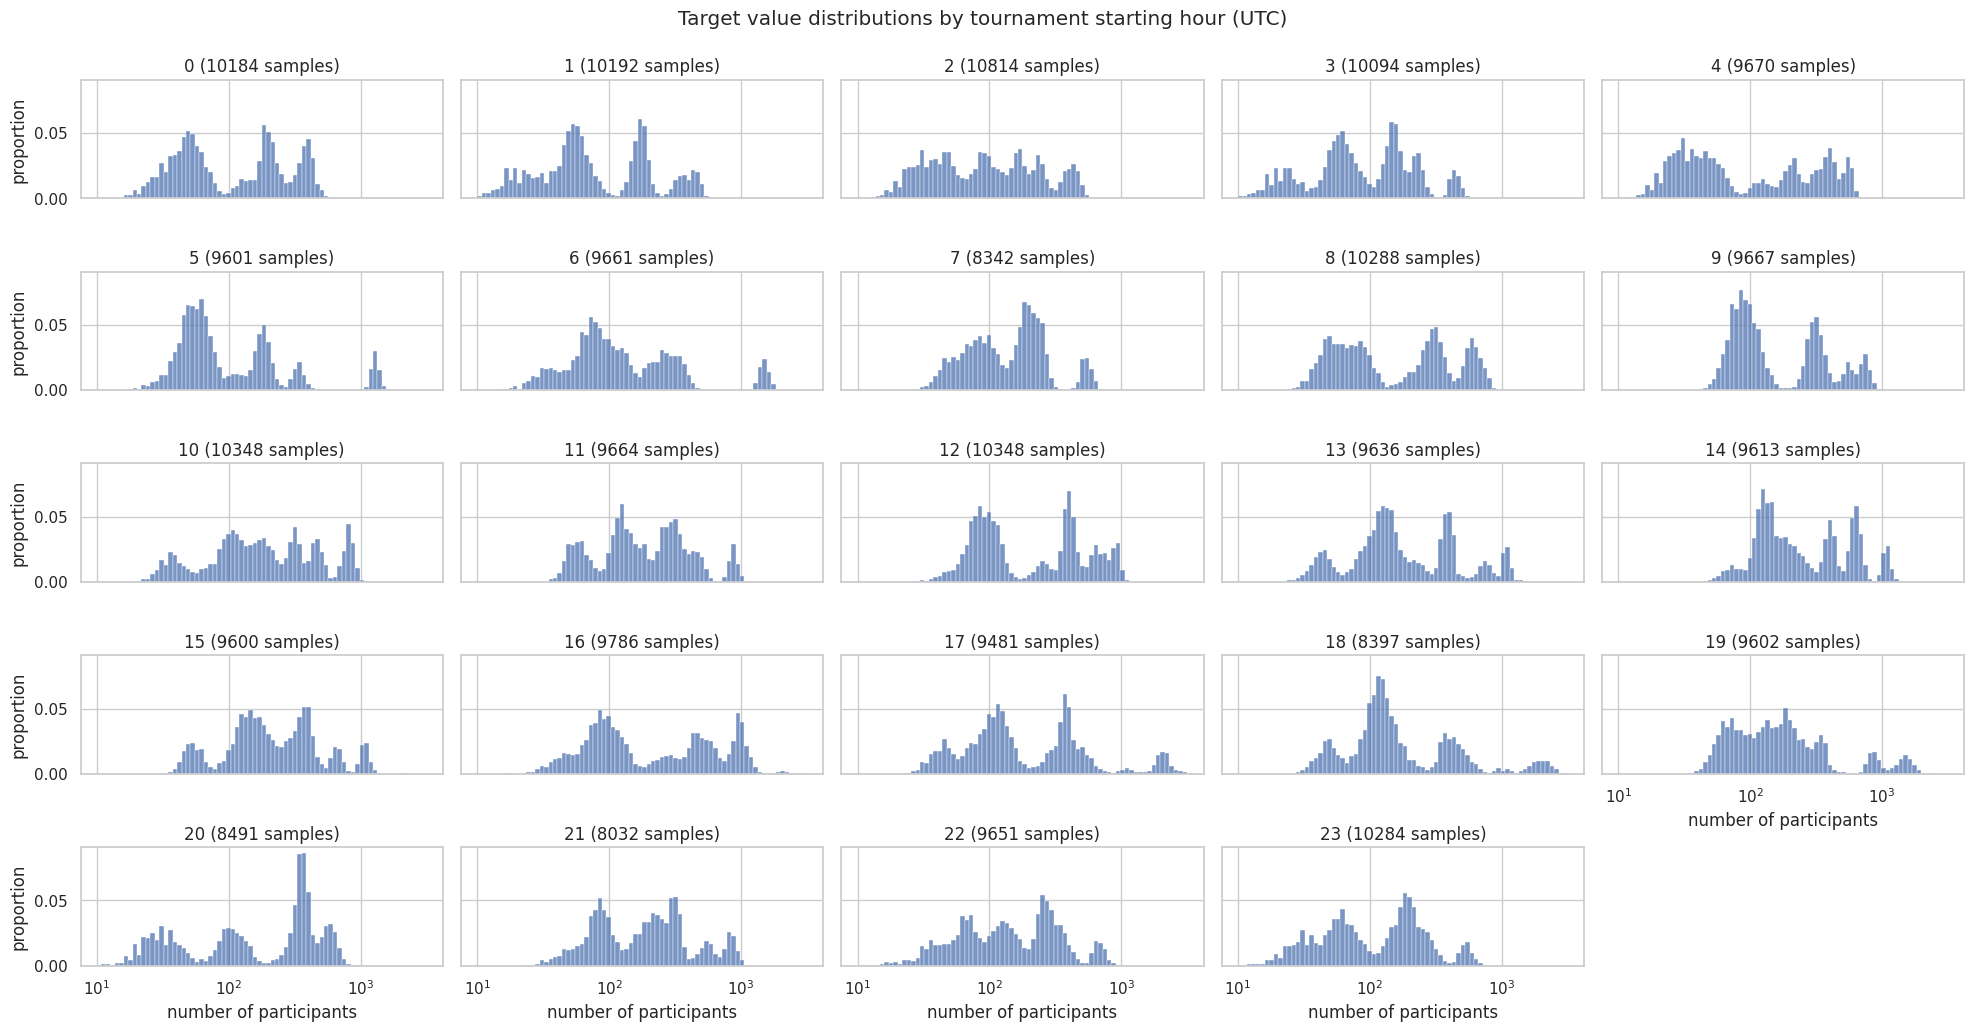

In [12]:
test_feature("starts_at_hour", "tournament starting hour (UTC)", col_wrap=5, col_order=range(24))

The tests do show these features are significant, but I definitely expected the month and especially the day of the week to have a bigger impact. The differences are barely visible on the plots.

### Binary features

I encoded some tournament metadata as binary features, such as `has_description`, `has_prizes` and `has_custom_position`. Other binary features come directly from the Lichess API.

Mann-Whitney U test: pvalue = 0.0
Median test: pvalue = 0.0


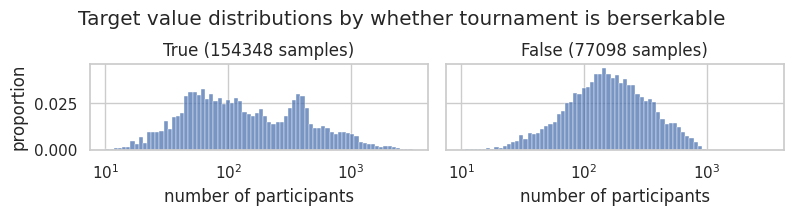

In [13]:
test_feature("berserkable", "whether tournament is berserkable")

Mann-Whitney U test: pvalue = 0.0
Median test: pvalue = 0.0


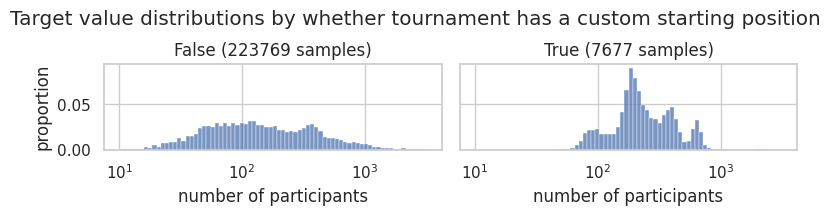

In [14]:
test_feature("has_custom_position", "whether tournament has a custom starting position")

Mann-Whitney U test: pvalue = 1.9260698290143216e-251
Median test: pvalue = 2.4858009446167826e-119


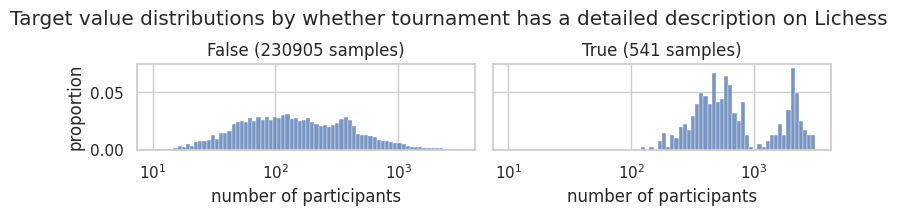

In [15]:
test_feature("has_description", "whether tournament has a detailed description on Lichess")

The remaining binary features don't make for good histograms, since one of the two values is very uncommon. Here are their statistical test results:

In [16]:
just_stat_test_features(["rated", "only_titled", "is_team", "has_prizes"])

,feature,count_False,count_True,mann_whitney,moon_median
0,rated,72,231374,2.381542e-33,3.407236e-16
1,only_titled,231401,45,2.187169e-12,3.356733e-10
2,is_team,231429,17,1.618556e-12,9.907600e-05
3,has_prizes,231374,72,2.204888e-29,4.710679e-17


### Numeric features

In [17]:
numeric_features = [
    "duration_mins", "clock_limit_secs", "clock_increment_secs", "min_rated_games", "min_rating", "max_rating"
]

These are the features that I consider to be semantically numeric. However, they are unusual in that they only have a limited number of possible values in the dataset:

In [18]:
df[numeric_features].nunique(dropna=False)

duration_mins           20
clock_limit_secs         9
clock_increment_secs     5
min_rated_games          6
min_rating               2
max_rating               5
dtype: int64

This is because features like tournament duration obviously aren't determined at random but tend to be round numbers like 30 minutes, 1 hour, etc.

Still, I consider these features numeric and not categorical because I would like my model to handle previously unseen values of these features in a way that makes sense (for example, it should be able to figure out that a 47-minute tournament is probably going to have more people than a 30-minute tournament, but less than a 1-hour tournament, even though it hasn't seen any exactly 47-minute tournaments in the dataset).

The features `min_rating` and `max_rating` are the minimum and maximum rating required to join a tournament. I use a heuristic to convert these ratings to quantiles ("what portion of the playerbase is worse than this rating"). This provides a sensible way to both scale these features to $[0, 1]$ and fill NaNs (`min_rating=0` and `max_rating=1` just means "everyone is allowed to participate"). The heuristic is as follows:

$$
q = \sigma\left(\frac{r - 1500}{300}\right)
$$

where $r$ is the rating, $q$ is the resulting quantile and $\sigma$ is the sigmoid function. This appears to produce a similar function to Lichess cumulative rating curves such as [this one](https://lichess.org/stat/rating/distribution/blitz). It's obviously not precise, though.

In [19]:
df_quant = preprocessing.ratings_to_quantiles(df)
df_fixed = preprocessing.fill_na(df_quant)    # fills NAs in min_rated_games with 0s

Here are the various correlations of each numeric feature with the target.

The Spearman rank and Kendall tau correlations are included to help detect non-linear monotonic relationships, which could be the case for features like `min_rated_games`.

In [20]:
pd.DataFrame({
    "pearson_corr": df_fixed[numeric_features].corrwith(df_fixed.n_players, method="pearson"),
    "spearman_corr": df_fixed[numeric_features].corrwith(df_fixed.n_players, method="spearman"),
    "kendall_corr": df_fixed[numeric_features].corrwith(df_fixed.n_players, method="kendall")
})

,pearson_corr,spearman_corr,kendall_corr
duration_mins,0.584805,0.368697,0.297018
clock_limit_secs,0.241140,0.363222,0.259770
clock_increment_secs,0.012028,-0.057507,-0.045802
min_rated_games,0.213958,0.383235,0.267702
min_rating,0.003834,0.021371,0.017473
max_rating,0.148394,-0.007985,0.011534


Based on these features, I've added the binary features `has_clock_increment`, `has_min_rated_games`, `has_min_rating`, `has_max_rating`, since any of these features being `False` seems like a special case that the model might want to handle separately. These features are significant according to statistical tests:

In [21]:
just_stat_test_features(["has_clock_increment", "has_min_rated_games", "has_min_rating", "has_max_rating"])

,feature,count_False,count_True,mann_whitney,moon_median
0,has_clock_increment,211179,20267,1.360634e-198,2.631853e-64
1,has_min_rated_games,70019,161427,0.000000e+00,0.000000e+00
2,has_min_rating,231261,185,8.573919e-25,1.005870e-37
3,has_max_rating,154350,77096,0.000000e+00,0.000000e+00


I've also dropped the `min_rating` feature from training for now. In the dataset it only has one unique non-NaN value, which effectively makes it a duplicate of `has_min_rating`.